In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import Imputer
from sklearn import preprocessing
from sklearn import decomposition
from sklearn.cross_validation import train_test_split

from pandas.tools.plotting import autocorrelation_plot
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from pandas.tseries.offsets import *
import statsmodels.api as sm
from statsmodels.tsa.stattools import acf, pacf

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

"""
import os
os.environ["PYSPARK_PYTHON"] = "/usr/bin/python"
from pyspark.sql import Row
from pyspark.sql.types import *
from pyspark.sql import HiveContext 

from pyspark import SparkContext, SparkConf
import pyspark

conf = SparkConf()
sc = SparkContext()
from pyspark.sql import SQLContext
sqlContext = SQLContext(sc)
hive_context=HiveContext(sc)"""

import warnings
warnings.filterwarnings("ignore")

C:\Users\Shantanu\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\Shantanu\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [3]:
df = pd.read_csv('sapsales.csv')
df.shape

(59500, 5)

In [3]:
#df.Material.value_counts()
df.material.nunique()

698

In [4]:
df['date'] = df['date'].apply(lambda x: pd.to_datetime(str(x), format='%Y%m%d'))

dum = ['material', 'plant']
df2 = df[dum]

dummy = pd.get_dummies(df2)

dummy['customer'] = df['customer']
dummy['qty'] = df['qty']
dummy['date'] = df['date']
dummy.head()

,material,plant_MY11,plant_MY21,plant_MY31,plant_MY41,plant_PH11,plant_SG11,plant_VN11,plant_VN12,plant_VN21,customer,qty,date
0,1000000,1,0,0,0,0,0,0,0,0,1000605,1.80,2017-05-31
1,1000000,1,0,0,0,0,0,0,0,0,1000605,0.92,2017-06-03
2,1000000,1,0,0,0,0,0,0,0,0,1000605,0.08,2017-06-06
3,1000000,1,0,0,0,0,0,0,0,0,1000605,0.16,2017-06-09
4,1000000,1,0,0,0,0,0,0,0,0,1000605,2.34,2017-06-13


In [5]:
dummy = dummy.set_index('date')
dummy.sort_index(ascending = True, inplace = True)
dummy.tail()

,material,plant_MY11,plant_MY21,plant_MY31,plant_MY41,plant_PH11,plant_SG11,plant_VN11,plant_VN12,plant_VN21,customer,qty
date,,,,,,,,,,,,
2018-02-15,1000341,1,0,0,0,0,0,0,0,0,1001199,2.00
2018-02-15,1000341,1,0,0,0,0,0,0,0,0,1001462,1.75
2018-02-15,1000223,0,1,0,0,0,0,0,0,0,1000744,0.10
2018-02-15,1000314,0,1,0,0,0,0,0,0,0,1001278,0.10
2018-02-15,1000246,0,0,1,0,0,0,0,0,0,1000902,0.12


In [6]:
dummy.index = pd.to_datetime(dummy.index)
temp = dummy.ix[(dummy.index.month != 2)]

temp.tail()

,material,plant_MY11,plant_MY21,plant_MY31,plant_MY41,plant_PH11,plant_SG11,plant_VN11,plant_VN12,plant_VN21,customer,qty
date,,,,,,,,,,,,
2018-01-31,1000875,0,0,0,0,0,0,1,0,0,1003594,0.800
2018-01-31,1000804,0,0,0,0,0,0,1,0,0,1003996,0.002
2018-01-31,1000307,0,1,0,0,0,0,0,0,0,1000718,0.000
2018-01-31,1000307,0,1,0,0,0,0,0,0,0,1001897,0.000
2018-01-31,1000804,0,0,0,0,0,0,1,0,0,1004083,0.002


In [124]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = pd.rolling_mean(timeseries, window=12, freq= 'M')
    rolstd = pd.rolling_std(timeseries, window=12, freq= 'M')

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    adf_results = {}
    for col in timeseries.columns.values:  #or edit this for a subset of columns first
        adf_results[col] = adfuller(timeseries[col])
    
    print (adf_results)
        
    
    #print ('Results of Dickey-Fuller Test:')
    #dftest = adfuller(timeseries, autolag='AIC')
    #dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','critical value','Number of Observations Used'])
    #for key,value in dftest[4].items():
        #dfoutput['Critical Value (%s)'%key] = value
    #print (dfoutput)

In [ ]:
plt.figure(figsize=(35,35))
temp.plot()
plt.show()

In [ ]:
test_stationarity(dummy)

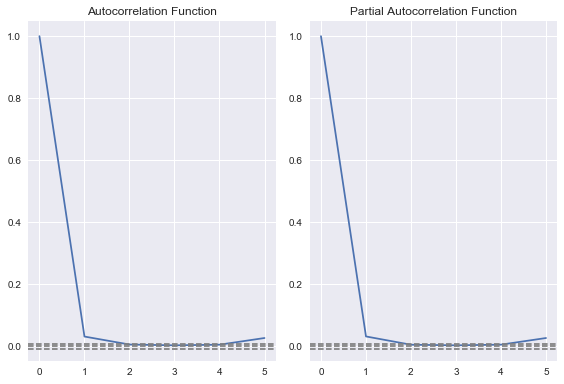

In [125]:
lag_acf = acf(dummy['qty'], nlags=5)
lag_pacf = pacf(dummy['qty'], nlags=5, method='ols')

#Plot ACF: 
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(dummy['qty'])),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(dummy['qty'])),linestyle='--',color='gray')
plt.title('Autocorrelation Function')


#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(dummy['qty'])),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(dummy['qty'])),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

In [7]:
import pyflux as pf
model = pf.ARIMAX(data=dummy, formula= 'qty~1+material+plant_MY11+plant_MY21+plant_MY31+plant_MY41+plant_PH11+plant_SG11+plant_VN11+plant_VN12+plant_VN21',
                  ar=2, ma=2, family=pf.Normal())
x = model.fit("MLE")
x.summary()

Normal ARIMAX(2,0,2)                                                                                      
======================================================= ==================================================
Dependent Variable: qty                                 Method: MLE                                       
Start Date: 2017-05-29 00:00:00                         Log Likelihood: -603599.8785                      
End Date: 2018-02-15 00:00:00                           AIC: 1207231.7571                                 
Number of observations: 59498                           BIC: 1207375.6562                                 
Latent Variable                          Estimate   Std Error  z        P>|z|    95% C.I.                 
======================================== ========== ========== ======== ======== =========================
AR(1)                                    0.0        0.0141     0.0      1.0      (-0.0277 | 0.0277)       
AR(2)                                

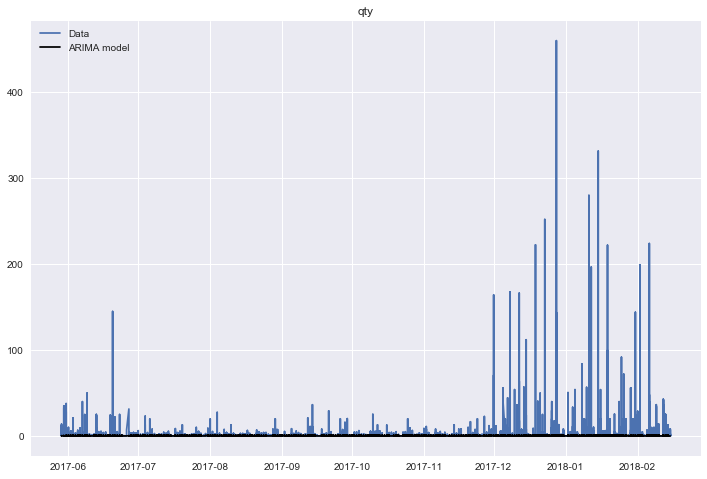

In [8]:
model.plot_fit(figsize=(12,8))

In [9]:
monthly = dummy.resample('M').mean()
monthly.head()

,material,plant_MY11,plant_MY21,plant_MY31,plant_MY41,plant_PH11,plant_SG11,plant_VN11,plant_VN12,plant_VN21,qty
date,,,,,,,,,,,
2017-05-31,1.796847e+06,0.479339,0.206612,0.090909,0.066116,0.0,0.157025,0.0,0.0,0.0,2.435009
2017-06-30,1.244814e+06,0.615838,0.141678,0.129691,0.108862,0.0,0.003930,0.0,0.0,0.0,0.395418
2017-07-31,1.228752e+06,0.625747,0.142303,0.120174,0.109837,0.0,0.001938,0.0,0.0,0.0,0.208606
2017-08-31,1.185917e+06,0.580740,0.162863,0.135028,0.119467,0.0,0.001902,0.0,0.0,0.0,0.229003
2017-09-30,1.235742e+06,0.615728,0.149598,0.117962,0.114209,0.0,0.002502,0.0,0.0,0.0,0.235733


In [10]:
monthly2 = temp.resample('M').mean()
monthly2.head()

,material,plant_MY11,plant_MY21,plant_MY31,plant_MY41,plant_PH11,plant_SG11,plant_VN11,plant_VN12,plant_VN21,qty
date,,,,,,,,,,,
2017-05-31,1.796847e+06,0.479339,0.206612,0.090909,0.066116,0.0,0.157025,0.0,0.0,0.0,2.435009
2017-06-30,1.244814e+06,0.615838,0.141678,0.129691,0.108862,0.0,0.003930,0.0,0.0,0.0,0.395418
2017-07-31,1.228752e+06,0.625747,0.142303,0.120174,0.109837,0.0,0.001938,0.0,0.0,0.0,0.208606
2017-08-31,1.185917e+06,0.580740,0.162863,0.135028,0.119467,0.0,0.001902,0.0,0.0,0.0,0.229003
2017-09-30,1.235742e+06,0.615728,0.149598,0.117962,0.114209,0.0,0.002502,0.0,0.0,0.0,0.235733


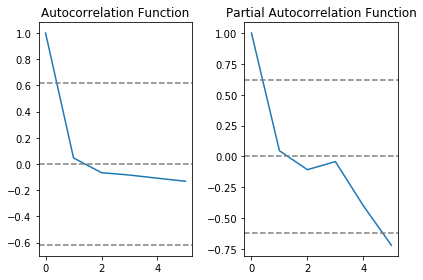

In [9]:
lag_acf = acf(monthly['qty'], nlags=5)
lag_pacf = pacf(monthly['qty'], nlags=5, method='ols')

#Plot ACF: 
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(monthly['qty'])),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(monthly['qty'])),linestyle='--',color='gray')
plt.title('Autocorrelation Function')


#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(monthly['qty'])),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(monthly['qty'])),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

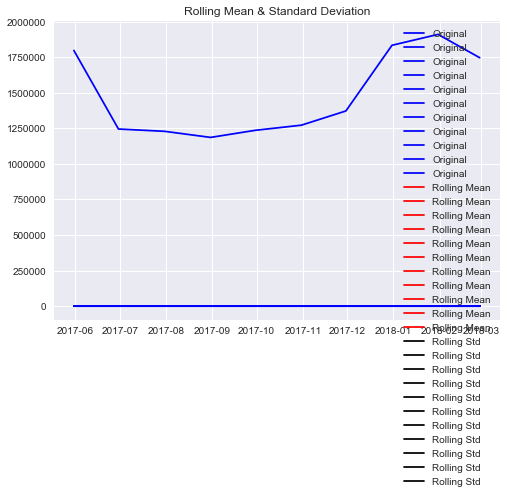

{'material': (0.0, 0.958532086060056, 5, 4, {'1%': -7.355440625, '5%': -4.474365000000001, '10%': -3.1269325}, -inf), 'plant_MY11': (-0.0, 0.958532086060056, 6, 3, {'1%': -10.41719074074074, '5%': -5.77838074074074, '10%': -3.391681111111111}, -158.06586356268807), 'plant_MY21': (-0.3086538856319643, 0.9242697090531503, 3, 6, {'1%': -5.354256481481482, '5%': -3.6462381481481483, '10%': -2.901197777777778}, -153.9069804793284), 'plant_MY31': (-0.0, 0.958532086060056, 5, 4, {'1%': -7.355440625, '5%': -4.474365000000001, '10%': -3.1269325}, -155.29327484044828), 'plant_MY41': (-0.0, 0.958532086060056, 7, 2, {'1%': -20.825625000000002, '5%': -10.37019, '10%': -4.03822}, -151.13439175708862), 'plant_PH11': (-1.0019229092397517, 0.7525623182750202, 3, 6, {'1%': -5.354256481481482, '5%': -3.6462381481481483, '10%': -2.901197777777778}, -160.83845228492785), 'plant_SG11': (-1.630647230925979, 0.46715194482347305, 1, 8, {'1%': -4.6651863281249994, '5%': -3.3671868750000002, '10%': -2.802960625}

In [126]:
test_stationarity(monthly)

In [11]:
import pyflux as pf
model = pf.ARIMAX(data=monthly, formula= 'qty~1+material+plant_MY11+plant_MY21+plant_MY31+plant_MY41+plant_PH11+plant_SG11+plant_VN11+plant_VN12+plant_VN21',
                  ar=2, ma=3, family=pf.Normal())
x = model.fit("MLE")
x.summary()

Normal ARIMAX(2,0,3)                                                                                      
======================================================= ==================================================
Dependent Variable: qty                                 Method: MLE                                       
Start Date: 2017-08-31 00:00:00                         Log Likelihood: 9.9184                            
End Date: 2018-02-28 00:00:00                           AIC: 14.1631                                      
Number of observations: 7                               BIC: 13.2436                                      
Latent Variable                          Estimate   Std Error  z        P>|z|    95% C.I.                 
======================================== ========== ========== ======== ======== =========================
AR(1)                                    0.1067     1612131.60 0.0      1.0      (-3159777.8405 | 3159778.
AR(2)                                

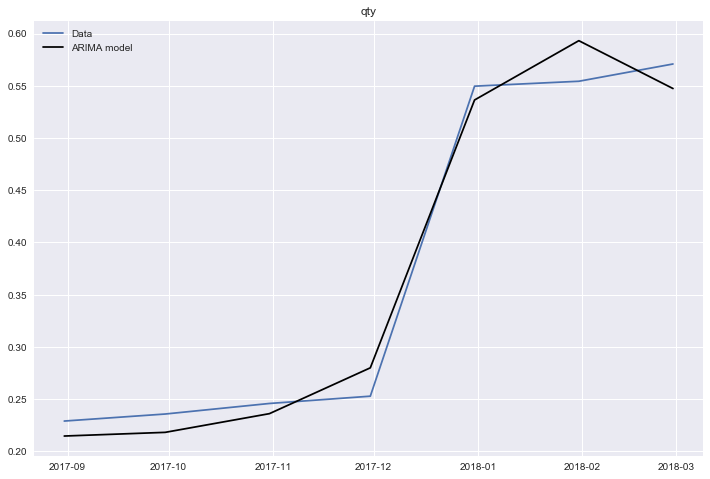

In [11]:
model.plot_fit(figsize=(12,8))

In [12]:
preds = model.predict(h = 7, oos_data = monthly, intervals=False)
accuracy = (preds['qty']/monthly.qty)*100
#accuracy = ((preds['qty'] - monthly.qty)/monthly.qty)*100
np.mean(accuracy)

90.00183103575955

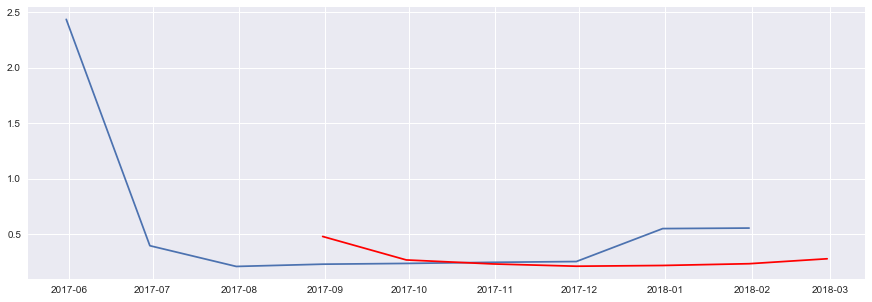

In [98]:
plt.figure(figsize=(15,5))
plt.plot(monthly2.qty)
plt.plot(preds, color = 'red')

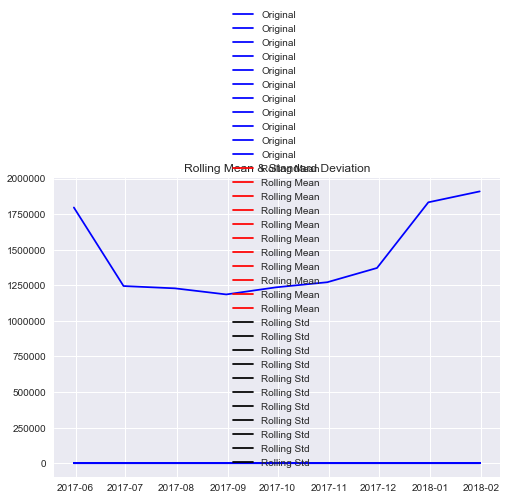

{'material': (0.0, 0.958532086060056, 3, 5, {'1%': -6.045114, '5%': -3.9292800000000003, '10%': -2.98681}, -inf), 'plant_MY11': (-0.3429112862033483, 0.9192030976742458, 1, 7, {'1%': -4.9386902332361515, '5%': -3.477582857142857, '10%': -2.8438679591836733}, -inf), 'plant_MY21': (-1.526274379420781, 0.5204760663011919, 0, 8, {'1%': -4.6651863281249994, '5%': -3.3671868750000002, '10%': -2.802960625}, -inf), 'plant_MY31': (-0.9071613082187782, 0.7856049486744109, 0, 8, {'1%': -4.6651863281249994, '5%': -3.3671868750000002, '10%': -2.802960625}, -inf), 'plant_MY41': (-1.421591098786433, 0.5718824281431031, 0, 8, {'1%': -4.6651863281249994, '5%': -3.3671868750000002, '10%': -2.802960625}, -inf), 'plant_PH11': (-1.5092710387063666, 0.5289202049722751, 0, 8, {'1%': -4.6651863281249994, '5%': -3.3671868750000002, '10%': -2.802960625}, -inf), 'plant_SG11': (0.0, 0.958532086060056, 3, 5, {'1%': -6.045114, '5%': -3.9292800000000003, '10%': -2.98681}, -inf), 'plant_VN11': (-0.34659095764619696, 

In [127]:
test_stationarity(monthly2)

In [13]:
import pyflux as pf
model2 = pf.ARIMAX(data=monthly2, formula= 'qty~1+material+plant_MY11+plant_MY21+plant_MY31+plant_MY41+plant_PH11+plant_SG11+plant_VN11+plant_VN12+plant_VN21',
                  ar=2, ma=2, family=pf.Normal())
x = model2.fit("MLE")
x.summary()

Normal ARIMAX(2,0,2)                                                                                      
======================================================= ==================================================
Dependent Variable: qty                                 Method: MLE                                       
Start Date: 2017-07-31 00:00:00                         Log Likelihood: 9.5673                            
End Date: 2018-01-31 00:00:00                           AIC: 12.8654                                      
Number of observations: 7                               BIC: 11.9999                                      
Latent Variable                          Estimate   Std Error  z        P>|z|    95% C.I.                 
======================================== ========== ========== ======== ======== =========================
AR(1)                                    0.0051     109794.913 0.0      1.0      (-215198.0246 | 215198.03
AR(2)                                

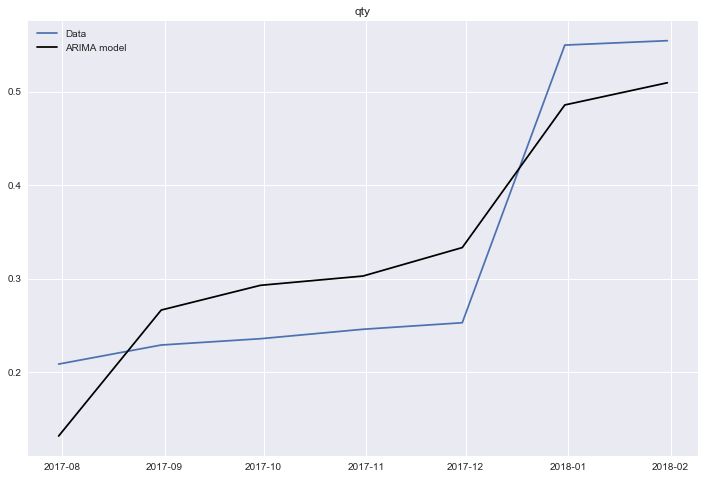

In [58]:
model2.plot_fit(figsize=(12,8))

In [121]:
preds2 = model2.predict(h = 7, oos_data = monthly, intervals= False)
#accuracy2 = (preds2['qty']/monthly2.qty)*100
accuracy2 = ((preds2['qty'] - monthly2.qty)/monthly2.qty)*100
np.mean(accuracy2)

12.166578657435435

In [122]:
preds2.tail()

,qty
date,
2017-09-30,0.274611
2017-10-31,0.275579
2017-11-30,0.288641
2017-12-31,0.299916
2018-01-31,0.329863


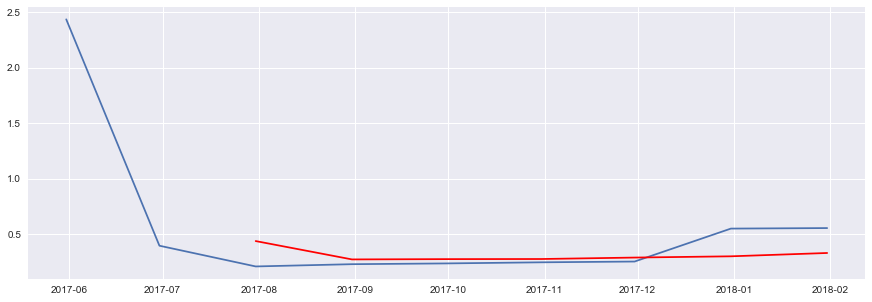

In [128]:
plt.figure(figsize=(15,5))
plt.plot(monthly2.qty)
plt.plot(preds2, color = 'red')

In [117]:
test = preds.ix[(preds.index.month == 2)]
test.head()

,qty
date,
2018-02-28,0.27774


In [118]:
actual = monthly.ix[(monthly.index.month == 2)]
actual.head()

,material,plant_MY11,plant_MY21,plant_MY31,plant_MY41,plant_PH11,plant_SG11,plant_VN11,plant_VN12,plant_VN21,qty
date,,,,,,,,,,,
2018-02-28,1.746004e+06,0.307964,0.093977,0.086036,0.075226,0.022502,0.00353,0.271343,0.087359,0.052063,0.570922


In [119]:
accuracy_feb = (test['qty']/actual.qty)*100
#accuracy_feb = ((test['qty'] - actual.qty)/actual.qty)*100
np.mean(accuracy_feb)

48.647684902547155

In [13]:
weekly = dummy.resample('W').mean()
weekly.tail()

,material,plant_MY11,plant_MY21,plant_MY31,plant_MY41,plant_PH11,plant_SG11,plant_VN11,plant_VN12,plant_VN21,qty
date,,,,,,,,,,,
2018-01-21,1.805378e+06,0.301967,0.081266,0.058597,0.093242,0.018820,0.000000,0.293841,0.097519,0.054748,0.693475
2018-01-28,1.828030e+06,0.376693,0.065654,0.054165,0.036931,0.031596,0.002052,0.276159,0.099302,0.057448,0.377622
2018-02-04,1.500110e+06,0.314620,0.125536,0.066667,0.073294,0.031969,0.006238,0.281871,0.049123,0.050682,0.491284
2018-02-11,2.011798e+06,0.277866,0.076831,0.066879,0.067675,0.010748,0.001592,0.317675,0.128583,0.052150,0.551522
2018-02-18,1.553688e+06,0.320463,0.092664,0.138996,0.084942,0.056628,0.003861,0.177606,0.060489,0.064350,0.738137


In [14]:
weekly2 = temp.resample('W').mean()
weekly2.head()

,material,plant_MY11,plant_MY21,plant_MY31,plant_MY41,plant_PH11,plant_SG11,plant_VN11,plant_VN12,plant_VN21,qty
date,,,,,,,,,,,
2017-06-04,1.404494e+06,0.592719,0.102389,0.156997,0.102389,0.0,0.045506,0.0,0.0,0.0,0.940165
2017-06-11,1.259097e+06,0.614686,0.155941,0.139439,0.085809,0.0,0.004125,0.0,0.0,0.0,0.428396
2017-06-18,1.350115e+06,0.664894,0.139818,0.117021,0.074468,0.0,0.003799,0.0,0.0,0.0,0.342106
2017-06-25,1.137403e+06,0.610680,0.166236,0.101637,0.118863,0.0,0.002584,0.0,0.0,0.0,0.502805
2017-07-02,1.216423e+06,0.536797,0.159091,0.140693,0.158009,0.0,0.005411,0.0,0.0,0.0,0.270593


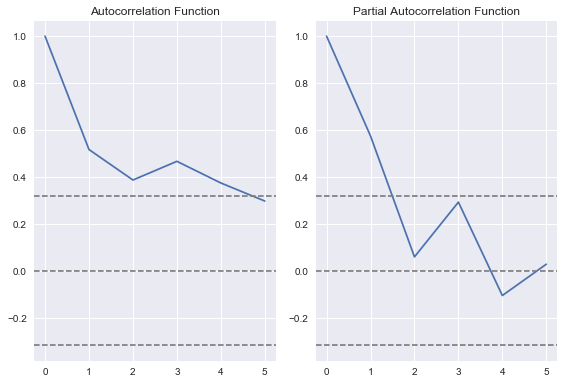

In [178]:
lag_acf = acf(weekly['qty'], nlags=5)
lag_pacf = pacf(weekly['qty'], nlags=5, method='ols')

#Plot ACF: 
plt.subplot(121)
#plt.figure(figsize=(10,10))
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(weekly['qty'])),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(weekly['qty'])),linestyle='--',color='gray')
plt.title('Autocorrelation Function')


#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(weekly['qty'])),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(weekly['qty'])),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

In [15]:
import pyflux as pf
model3 = pf.ARIMAX(data=weekly, formula= 'qty~1+material+plant_MY11+plant_MY21+plant_MY31+plant_MY41+plant_PH11+plant_SG11+plant_VN11+plant_VN12+plant_VN21',
                  ar=5, ma=3, family=pf.Normal())
x = model3.fit("MLE")
x.summary()

Normal ARIMAX(5,0,3)                                                                                      
======================================================= ==================================================
Dependent Variable: qty                                 Method: MLE                                       
Start Date: 2017-07-09 00:00:00                         Log Likelihood: 28.2821                           
End Date: 2018-02-18 00:00:00                           AIC: -16.5641                                     
Number of observations: 33                              BIC: 13.366                                       
Latent Variable                          Estimate   Std Error  z        P>|z|    95% C.I.                 
======================================== ========== ========== ======== ======== =========================
AR(1)                                    0.0226     0.4198     0.0539   0.9571   (-0.8003 | 0.8455)       
AR(2)                                

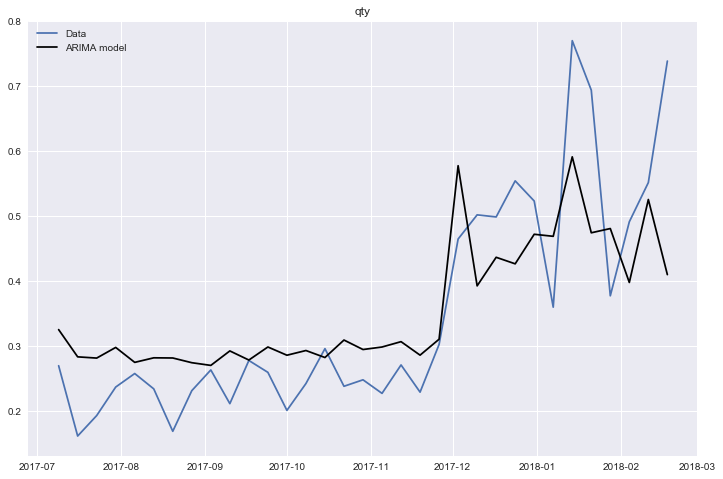

In [16]:
model3.plot_fit(figsize=(12,8))

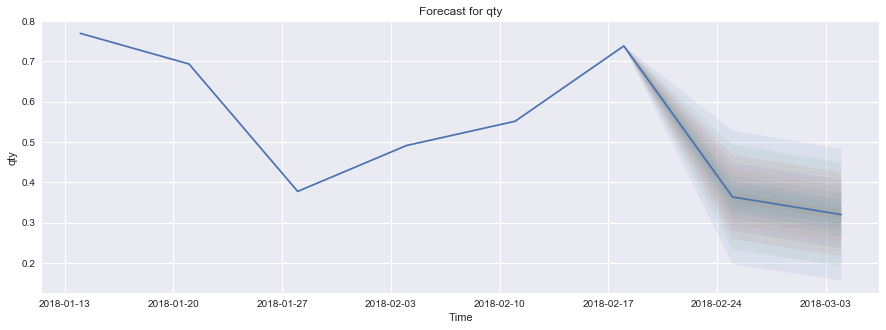

In [17]:
model3.plot_predict(h=2, oos_data= weekly, past_values=6, figsize=(15,5))

In [18]:
preds3 = model3.predict(h =2, oos_data = weekly, intervals=False)
accuracy3 = (preds3['qty']/weekly.qty)*100
#accuracy3 = ((preds['qty'] - weekly.qty)/monthly.qty)*100
np.mean(accuracy3)

nan

In [19]:
preds3

,qty
date,
2018-02-25,0.363911
2018-03-04,0.320213


In [21]:
import pyflux as pf
model4 = pf.ARIMAX(data=weekly2, formula= 'qty~1+material+plant_MY11+plant_MY21+plant_MY31+plant_MY41+plant_PH11+plant_SG11+plant_VN11+plant_VN12+plant_VN21',
                  ar=7, ma=3, family=pf.Normal())
x = model4.fit("MLE")
x.summary()

Normal ARIMAX(7,0,3)                                                                                      
======================================================= ==================================================
Dependent Variable: qty                                 Method: MLE                                       
Start Date: 2017-07-23 00:00:00                         Log Likelihood: 29.926                            
End Date: 2018-02-04 00:00:00                           AIC: -15.852                                      
Number of observations: 29                              BIC: 14.2285                                      
Latent Variable                          Estimate   Std Error  z        P>|z|    95% C.I.                 
======================================== ========== ========== ======== ======== =========================
AR(1)                                    0.0201     0.3498     0.0574   0.9542   (-0.6654 | 0.7056)       
AR(2)                                

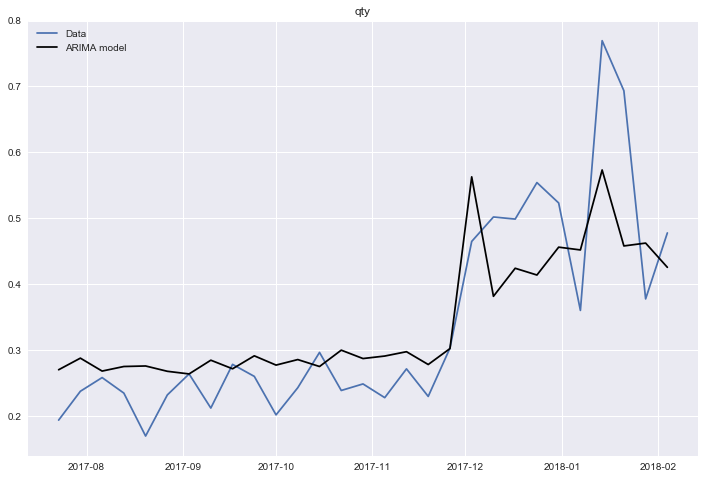

In [22]:
model4.plot_fit(figsize=(12,8))

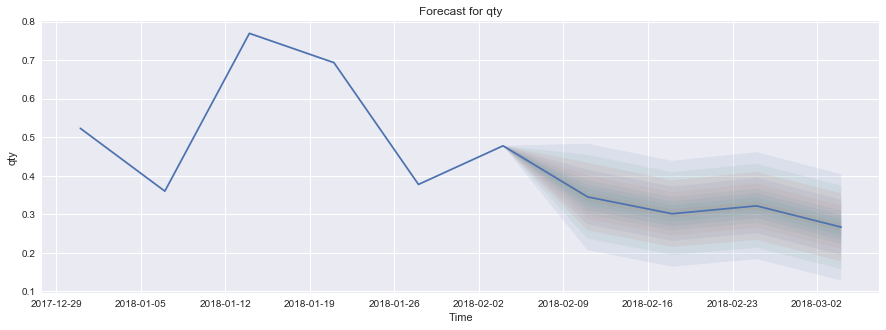

In [23]:
model4.plot_predict(h=4, oos_data= weekly2, past_values=6, figsize=(15,5))

In [24]:
preds4 = model4.predict(h =3, oos_data = weekly2, intervals=False)
accuracy = (preds4['qty']/weekly.qty)*100
#accuracy = ((preds['qty'] - weekly.qty)/monthly.qty)*100
np.mean(accuracy)

51.73484283558161

In [25]:
preds4

,qty
date,
2018-02-11,0.345306
2018-02-18,0.301603
2018-02-25,0.322010


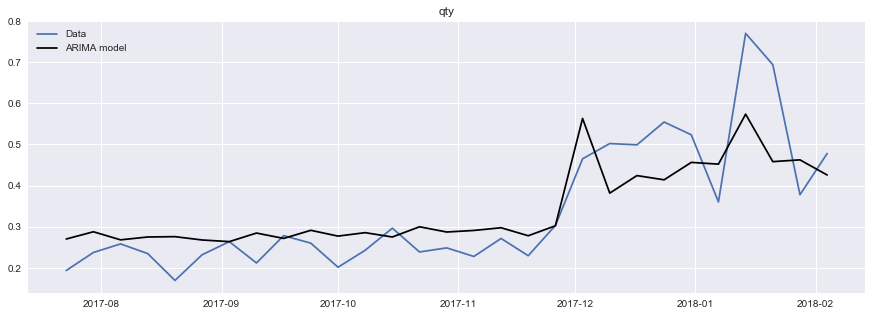

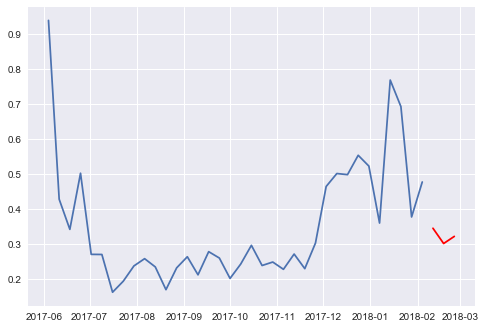

In [26]:
plt.figure(figsize=(15,5))
model4.plot_fit(figsize=(15,5))
plt.plot(weekly2['qty'])
plt.plot(preds4, color = 'red')

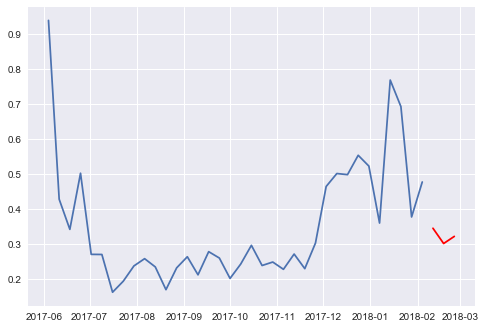

In [27]:
plt.plot(weekly2['qty'])
plt.plot(preds4, color = 'red')

In [28]:
pre = model4.predict_is(h =20, intervals=False)
accuracy = (pre['qty']/weekly.qty)*100
#accuracy = ((preds['qty'] - weekly.qty)/monthly.qty)*100
np.mean(accuracy)

81.76059451516083

In [29]:
march = model4.predict(h =6, oos_data = weekly, intervals=False)

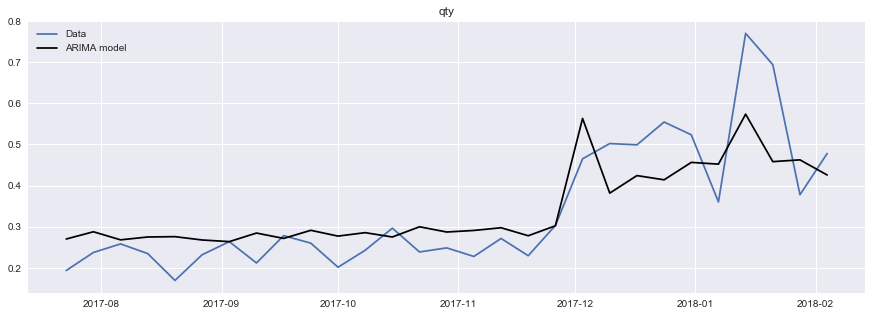

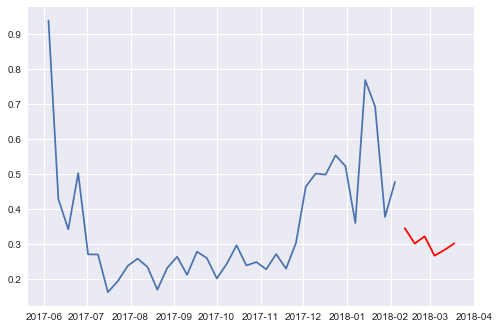

In [30]:
#plt.figure(figsize=(15,5))
model4.plot_fit(figsize=(15,5))
plt.plot(weekly2['qty'])
plt.plot(march, color = 'red')

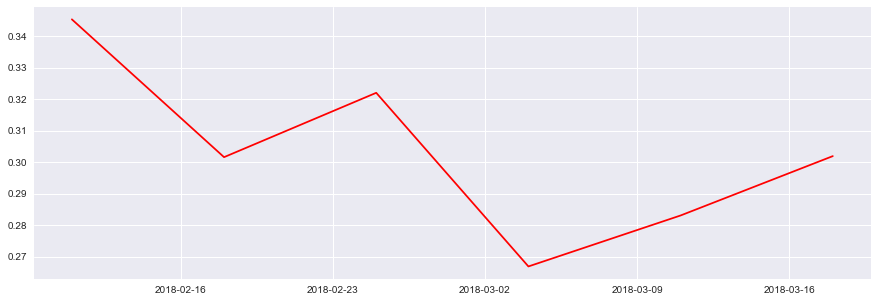

In [31]:
plt.figure(figsize=(15,5))

plt.plot(march, color = 'red')

In [42]:
df = pd.read_csv('test_sales1.csv')
df.shape

(1503, 5)

In [43]:
df.tail()

,material,plant,date,customer,qty
1498,1000295,MY21,20170815,1002700,2.880
1499,1000314,MY21,20171023,1001897,13.032
1500,1000310,MY31,20171120,1001757,3.600
1501,1000015,MY21,20171206,1000718,34.200
1502,1000005,MY11,20180118,1000243,1.908


In [44]:
df['date'] = df['date'].apply(lambda x: pd.to_datetime(str(x), format='%Y%m%d'))

dum = ['material', 'plant']
df2 = df[dum]

dummy1 = pd.get_dummies(df2)

dummy1['customer'] = df['customer']
dummy1['qty'] = df['qty']
dummy1['date'] = df['date']
dummy1.head()

,material,plant_ MY11,plant_ MY21,plant_ MY31,plant_ MY41,plant_ PH11,plant_ SG11,plant_ VN11,plant_ VN12,plant_ VN21,customer,qty,date
0,1000286,1,0,0,0,0,0,0,0,0,1002043,0.072,2017-11-27
1,1000295,1,0,0,0,0,0,0,0,0,1000263,10.800,2018-01-10
2,1000000,1,0,0,0,0,0,0,0,0,1000605,8.496,2017-10-19
3,1000233,1,0,0,0,0,0,0,0,0,1000572,2.232,2017-12-07
4,1001070,0,0,0,0,0,0,0,0,1,1004225,7.200,2017-12-25


In [45]:
dummy1 = dummy1.set_index('date')
dummy1.sort_index(ascending = True, inplace = True)
dummy1.tail()

,material,plant_ MY11,plant_ MY21,plant_ MY31,plant_ MY41,plant_ PH11,plant_ SG11,plant_ VN11,plant_ VN12,plant_ VN21,customer,qty
date,,,,,,,,,,,,
2018-02-21,1000005,1,0,0,0,0,0,0,0,0,1000445,0.005
2018-02-21,1000026,1,0,0,0,0,0,0,0,0,1000852,0.005
2018-02-21,1000003,1,0,0,0,0,0,0,0,0,1000430,0.010
2018-02-21,1000201,1,0,0,0,0,0,0,0,0,1000836,0.100
2018-02-21,1000005,1,0,0,0,0,0,0,0,0,1000280,0.030


In [47]:
dummy1.index = pd.to_datetime(dummy1.index)
temp = dummy.ix[(dummy.index.month == 2) & (dummy.index.day > 18)]

temp.tail()

,material,plant_MY11,plant_MY21,plant_MY31,plant_MY41,plant_PH11,plant_SG11,plant_VN11,plant_VN12,plant_VN21,customer,qty
date,,,,,,,,,,,,


In [51]:
temp = dummy1.ix[(dummy1.index > "2018-02-18")]
temp.head()

,material,plant_ MY11,plant_ MY21,plant_ MY31,plant_ MY41,plant_ PH11,plant_ SG11,plant_ VN11,plant_ VN12,plant_ VN21,customer,qty
date,,,,,,,,,,,,
2018-02-19,1001262,0,0,0,0,1,0,0,0,0,1006019,0.000
2018-02-19,1000053,0,0,0,1,0,0,0,0,0,1001828,22.500
2018-02-20,1000305,0,0,0,1,0,0,0,0,0,1000380,4.000
2018-02-20,8300009,1,0,0,0,0,0,0,0,0,1000897,0.048
2018-02-20,1000054,0,0,0,1,0,0,0,0,0,1001938,3.200


In [52]:
weekly_test = temp.resample('W').mean()
weekly_test.head()

,material,plant_ MY11,plant_ MY21,plant_ MY31,plant_ MY41,plant_ PH11,plant_ SG11,plant_ VN11,plant_ VN12,plant_ VN21,qty
date,,,,,,,,,,,
2018-02-25,1.561739e+06,0.615385,0.0,0.076923,0.230769,0.076923,0.0,0.0,0.0,0.0,2.335231


In [55]:
preds4 = model4.predict(h =3, oos_data = weekly, intervals=False)
accuracy = (preds4['qty']/weekly_test.qty)*100
#accuracy = ((preds['qty'] - weekly.qty)/monthly.qty)*100
np.mean(accuracy)

13.78922643446239